In [1]:

suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(randomForest))
suppressMessages(library(harmony))

# Plot each clusters
myHighlightDimPlot = function(seuratObj, highlightBy, size=1, alpha=1, showAllPoints=FALSE, ...) {
    umapTb = as_tibble(seuratObj@reductions$umap@cell.embeddings)
    if (!identical(rownames(seuratObj@reductions$umap@cell.embeddings), rownames(seuratObj@meta.data)))
        stop("Error: cell names not identical!")
    umapTb = cbind(umapTb, seuratObj@meta.data)
    highlightByClass = sort(unique(umapTb[[highlightBy]]))
    gpList = lapply(highlightByClass, function(cl) {
        subUmapTb = subset(umapTb, umapTb[[highlightBy]] == cl)
        if (showAllPoints) {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void() 
        } else {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void()
        }
        return(gp)
    })
    gpAll = plot_grid(plotlist=gpList, labels=highlightByClass, ...)
    return(gpAll)
}

In [2]:
seurat=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/renew_sndata_0619_mouse_mamoset/20230619.cla_snrna/mamoset/mamoset_snrna_all_soupX_unfil_0619.rds')

seurat


An object of class Seurat 
32919 features across 185473 samples within 1 assay 
Active assay: RNA (32919 features, 0 variable features)

In [3]:
table(seurat@meta.data$group)
length(unique(seurat@meta.data$group))


2192-1 2192-2 2192-3 2192-4 2192-5 2192-6 2192-7 2192-8 2192-9 2193-1 2193-2 
 13736   6737   6955   6667   7093   5807   6829   7094   6940   7043   7287 
2193-3 2193-4 2193-5 2193-6 2193-7 2193-8 2194-1 2194-9 6708-1 6708-2 6708-3 
  7286   7265   7456   7318   7542   7868  19644   6468   8022   8303   7798 
6708-4 
  8315 

[1] 23

In [4]:
#去除 median nfeature <500
df_meta=seurat@meta.data
group_med_feature=df_meta %>% group_by(group)  %>% summarise(med=median(nFeature_RNA))
select_group=group_med_feature[group_med_feature$med > 500,]$group
#被去掉的文库
length(group_med_feature$group)
group_med_feature[group_med_feature$med < 500,]$group
length(select_group)

seurat=subset(seurat,group %in% select_group)




[1] 23

character(0)

[1] 23

In [5]:
seurat

An object of class Seurat 
32919 features across 185473 samples within 1 assay 
Active assay: RNA (32919 features, 0 variable features)

In [6]:
MTGenes = c("ND6","COX3","COX1","ND5","ND4","ND2","ND4L","ATP8","CYTB","COX2","ND3","ATP6","ND1")
seurat[["percent.mt"]] <- PercentageFeatureSet(seurat,features  = MTGenes)



In [7]:
libMetaTb = read_xlsx(paste0(
    "/home/liuyx/liuyuxuan/spa_seurat/cla", 
    "/sample_lib_meta.xlsx"
))
libMetaTb=libMetaTb[,c('tissue','sampleID')]
colnames(libMetaTb)=c('sampleId','sampleID')
libMetaTb$libId=str_extract(libMetaTb$sampleID,'[0-9][0-9][0-9][0-9]-[0-9]')
libMetaTb$sampleID=NULL
libMetaTb=libMetaTb[!(is.na(libMetaTb$libId)),]
head(libMetaTb)

New names:
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`


sampleId    libId 
1 Cla-rostral 6103-1
2 Cla-rostral 6103-2
3 Cla-rostral 6103-3
4 Cla-rostral 6103-4
5 Cla-rostral 6103-5
6 Cla-rostral 6103-6

In [8]:
seurat@meta.data$libId=seurat@meta.data$group

tmpMetaTb = as_tibble(seurat@meta.data[c("libId")])
tmpMetaTb$cellId = rownames(seurat@meta.data)
tmpMetaTb = left_join(tmpMetaTb, libMetaTb[c("sampleId", "libId")], by="libId")
tmpMetaTb = column_to_rownames(tmpMetaTb, var="cellId")
identical(rownames(tmpMetaTb), rownames(seurat@meta.data))
# str(tmpMetaTb)
seurat = AddMetaData(seurat, tmpMetaTb)
seurat$sampleId = factor(seurat$sampleId)
seurat$libId = factor(seurat$libId)

setdiff(libMetaTb$libId, unique(seurat$libId))
length(setdiff(libMetaTb$libId, unique(seurat$libId)))



[1] TRUE

[1] "6103-1" "6103-2" "6103-3" "6103-4" "6103-5" "6103-6" "6712-1" "6712-2"
 [9] "6712-3" "6712-4" "7220-1" "7220-2" "7221-1" "7221-2" "7222-1" "7222-2"
[17] "7223-1" "7223-2" "7224-1" "7224-2" "7230-1" "7230-2" "7231-1" "7231-2"
[25] "7231-3" "7232-1" "7232-2" "7232-3" "7248-1" "7248-2"

[1] 30

In [9]:
# Basic filtering
#修改为200
oriCellNum = ncol(seurat)
seurat$countFeatureRatio = seurat$nCount_RNA / seurat$nFeature_RNA
seurat = subset(seurat, nFeature_RNA > 300 & percent.mt < 5 & countFeatureRatio > 1.2)
cellNum1 = ncol(seurat)
cellNum1
message("Filter ratio: ", cellNum1/oriCellNum)



[1] 178200

Filter ratio: 0.960786745240547



Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


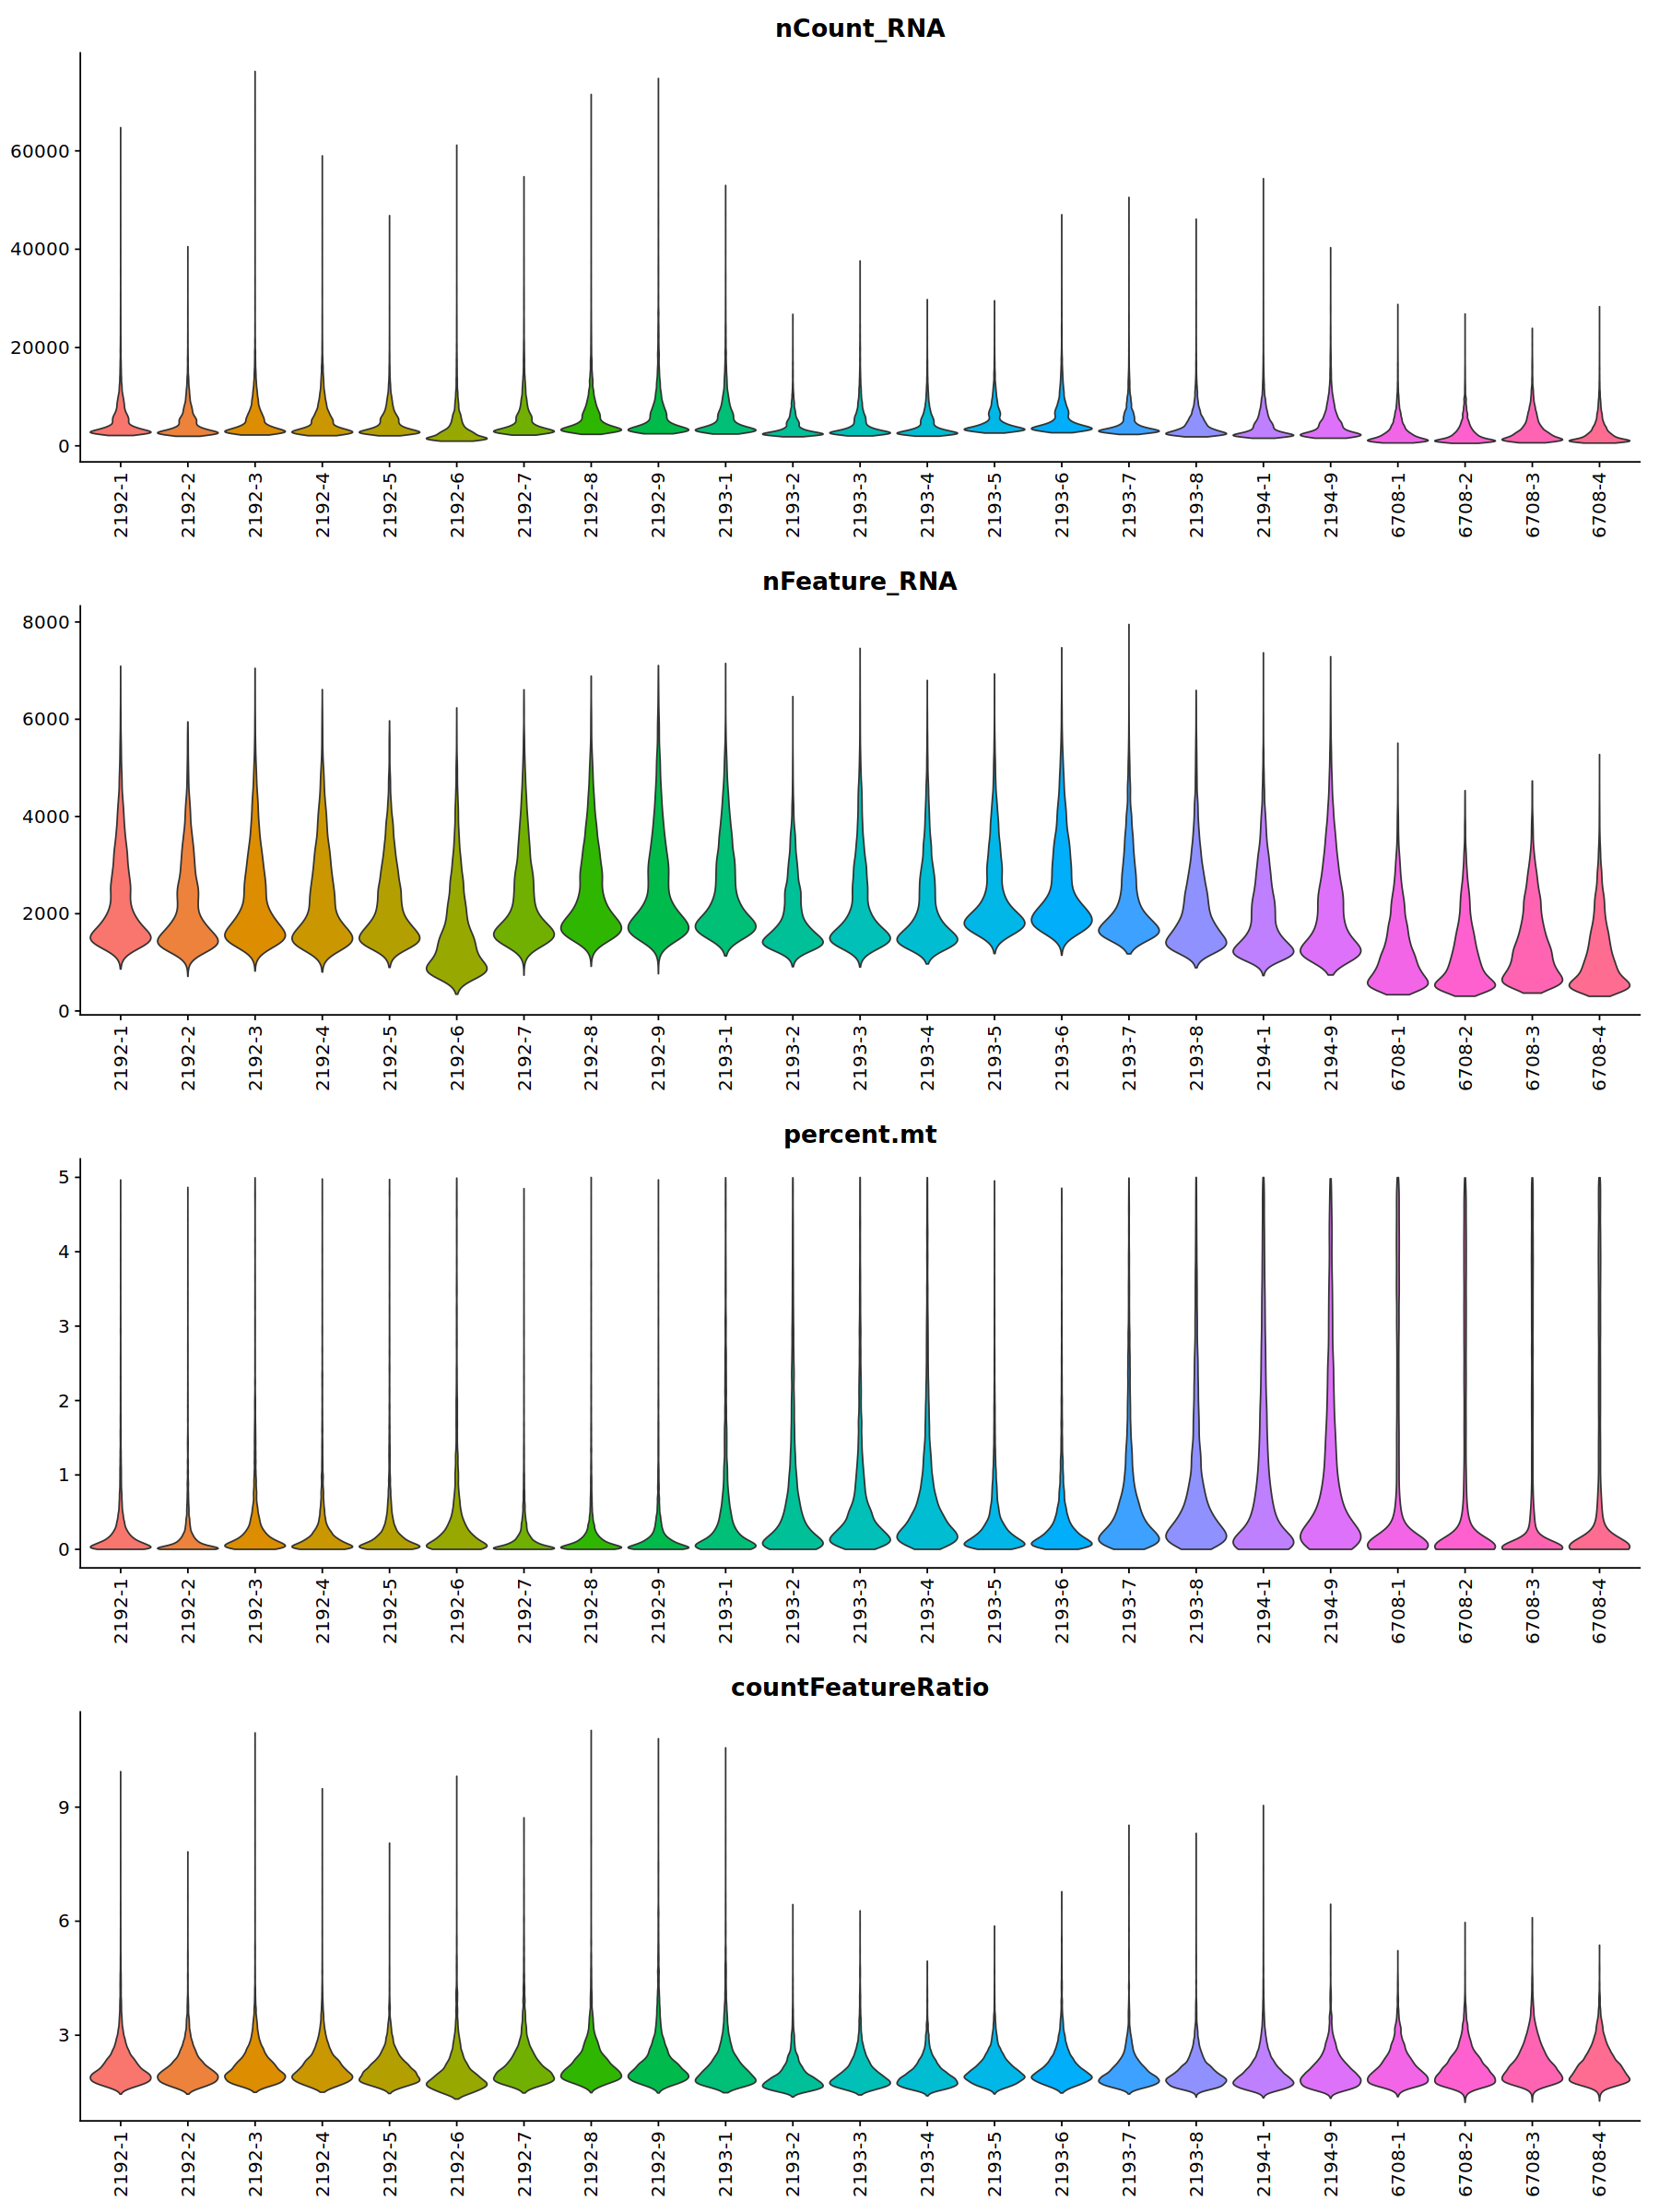

In [10]:
Idents(seurat) = "libId"
options(repr.plot.width=15, repr.plot.height=20)
print(plot_grid(
    plotlist = lapply(c("nCount_RNA", "nFeature_RNA", "percent.mt", "countFeatureRatio"), function(x) {
        p = VlnPlot(seurat, features=x, pt.size=0) + 
            theme(axis.text.x=element_text(vjust=0.5, hjust=0.5, angle=90), axis.title.x = element_blank()) +
            guides(fill=FALSE)
        return(p)
    }), 
    ncol=1, align="hv", axis="tblr"
))

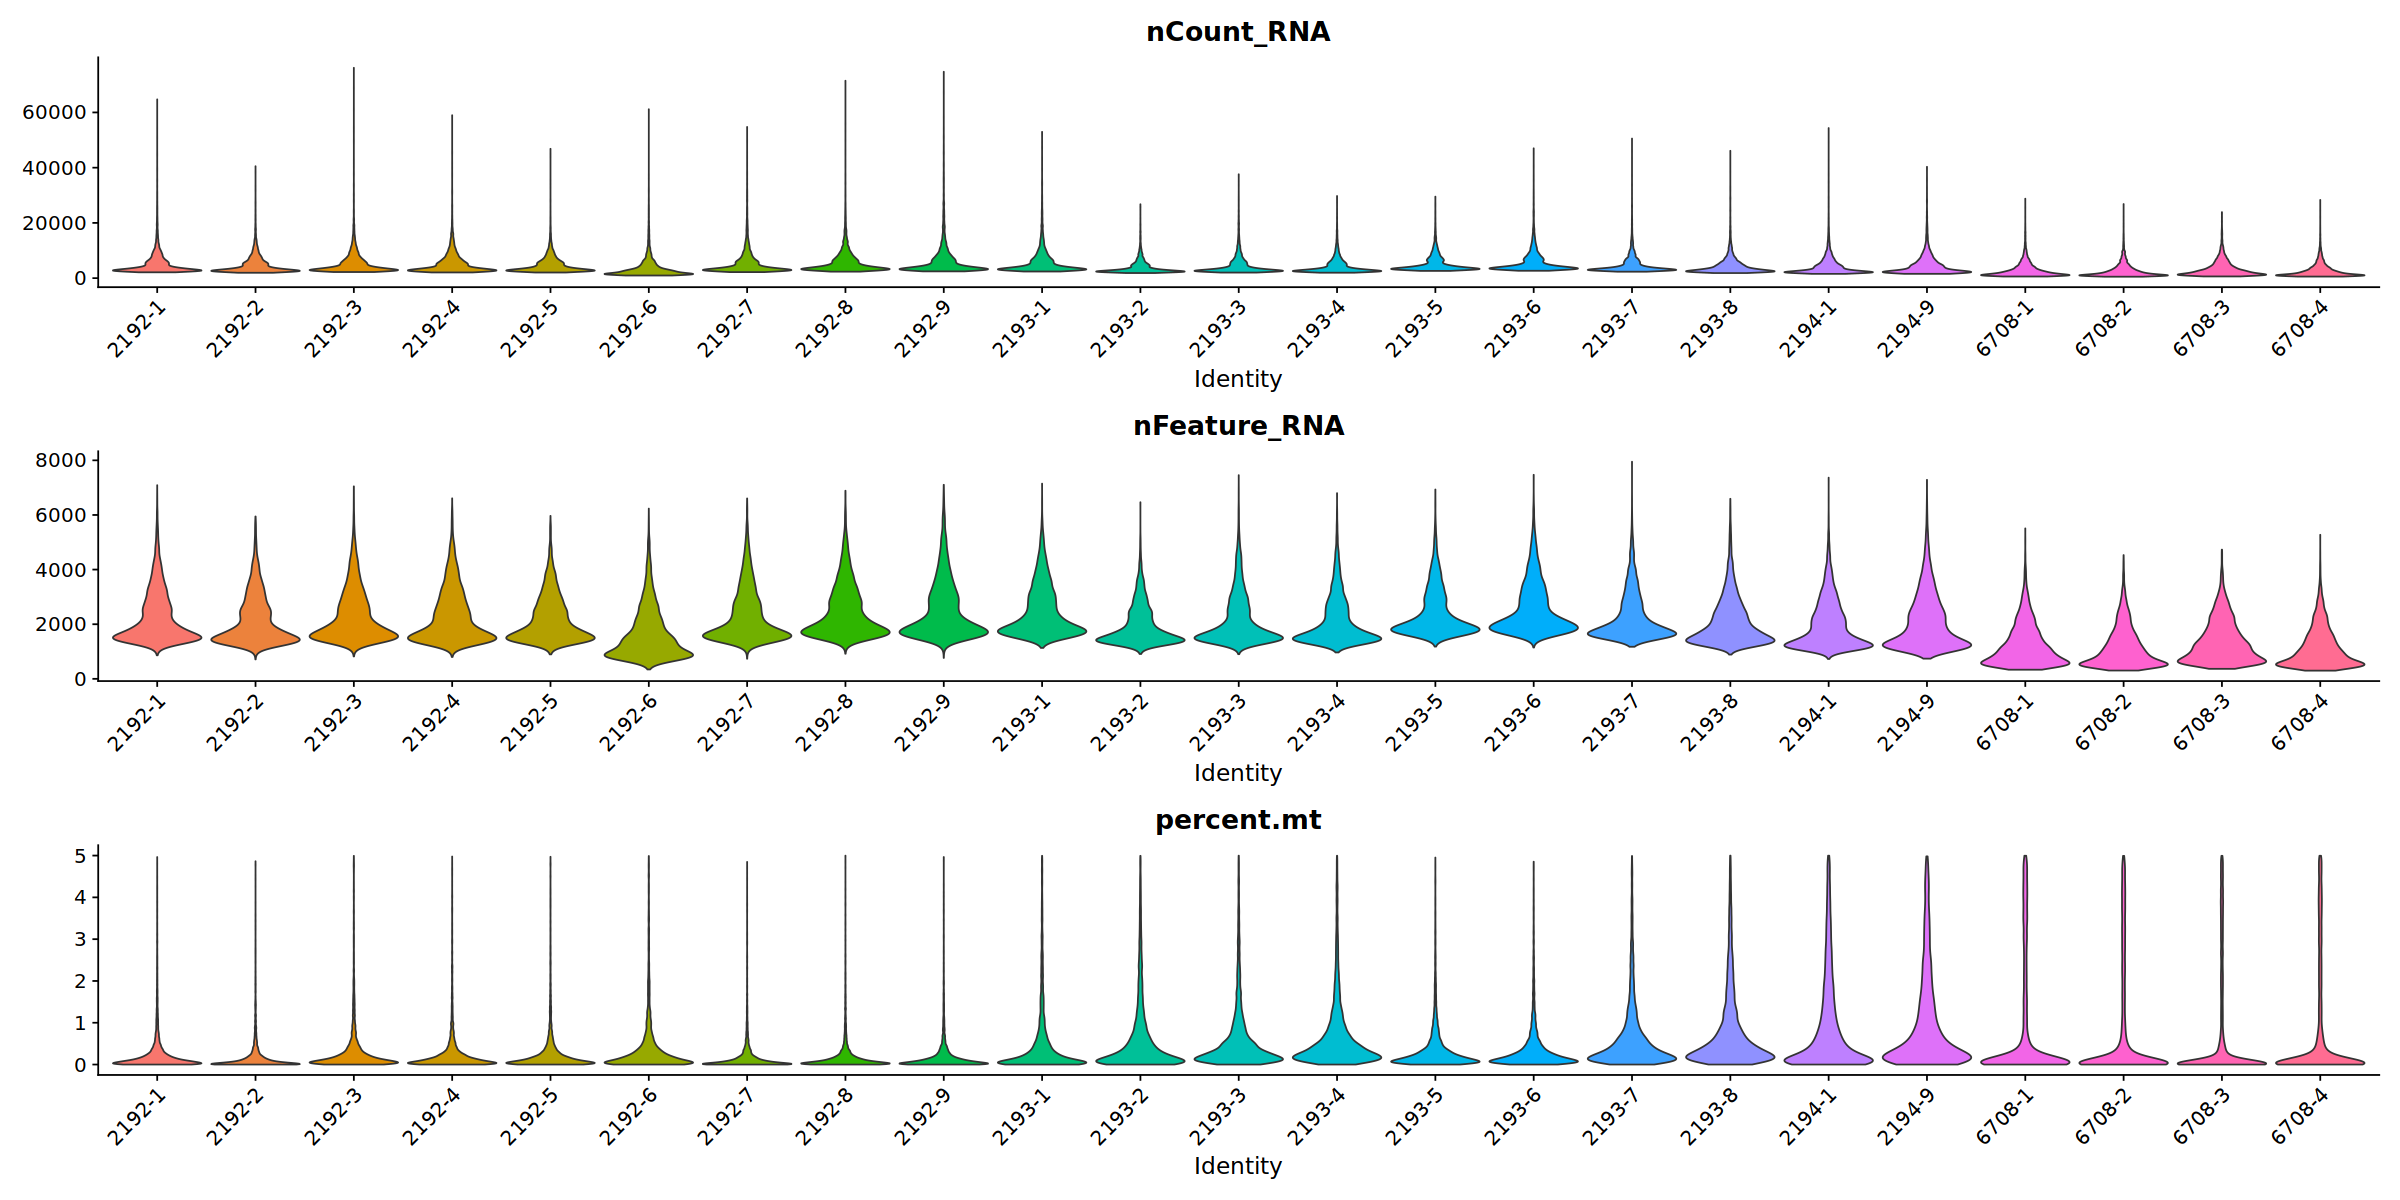

In [11]:
options(repr.plot.width=20, repr.plot.height=10)
Idents(seurat) = "libId"
VlnPlot(seurat, features=c("nCount_RNA", "nFeature_RNA", "percent.mt"), pt.size=0, ncol=1)

In [12]:
seurat

An object of class Seurat 
32919 features across 178200 samples within 1 assay 
Active assay: RNA (32919 features, 0 variable features)

In [13]:
#更新版本
saveRDS(seurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/marmoset/batch_normalize_renew_1031_marmoset/marmoset_snrna_all_soupX_fil_batch1_0619.rds')



In [14]:
#原有mt不正确版本
saveRDS(seurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/marmoset/0619snrna_data/marmoset_snrna_all_soupX_fil_0619.rds')



In [ ]:
# Do sct together
seurat = SCTransform(
    seurat, assay="RNA",
    ncells=ncol(seurat[["RNA"]]), 
    variable.features.n=5000,
#         vars.to.regress="percent.mt",
    return.only.var.genes = T,
    method="glmGamPoi"
) 
seurat = seurat %>%
    RunPCA(npcs=100, verbose = FALSE) %>%
    FindNeighbors(dims = 1:50) %>%
    FindClusters(verbose = FALSE) %>%
    RunUMAP(dims = 1:50)
options(repr.plot.width=6, repr.plot.height=2.5)
ElbowPlot(seurat, reduction = "pca", ndims=50)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 30768 by 170385

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 170385 cells



  |                                                                      |   0%

In [2]:
seurat=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/marmoset/0619snrna_data/marmoset_snrna_all_soupX_fil800_SCT_0619_anno_SCT.rds')




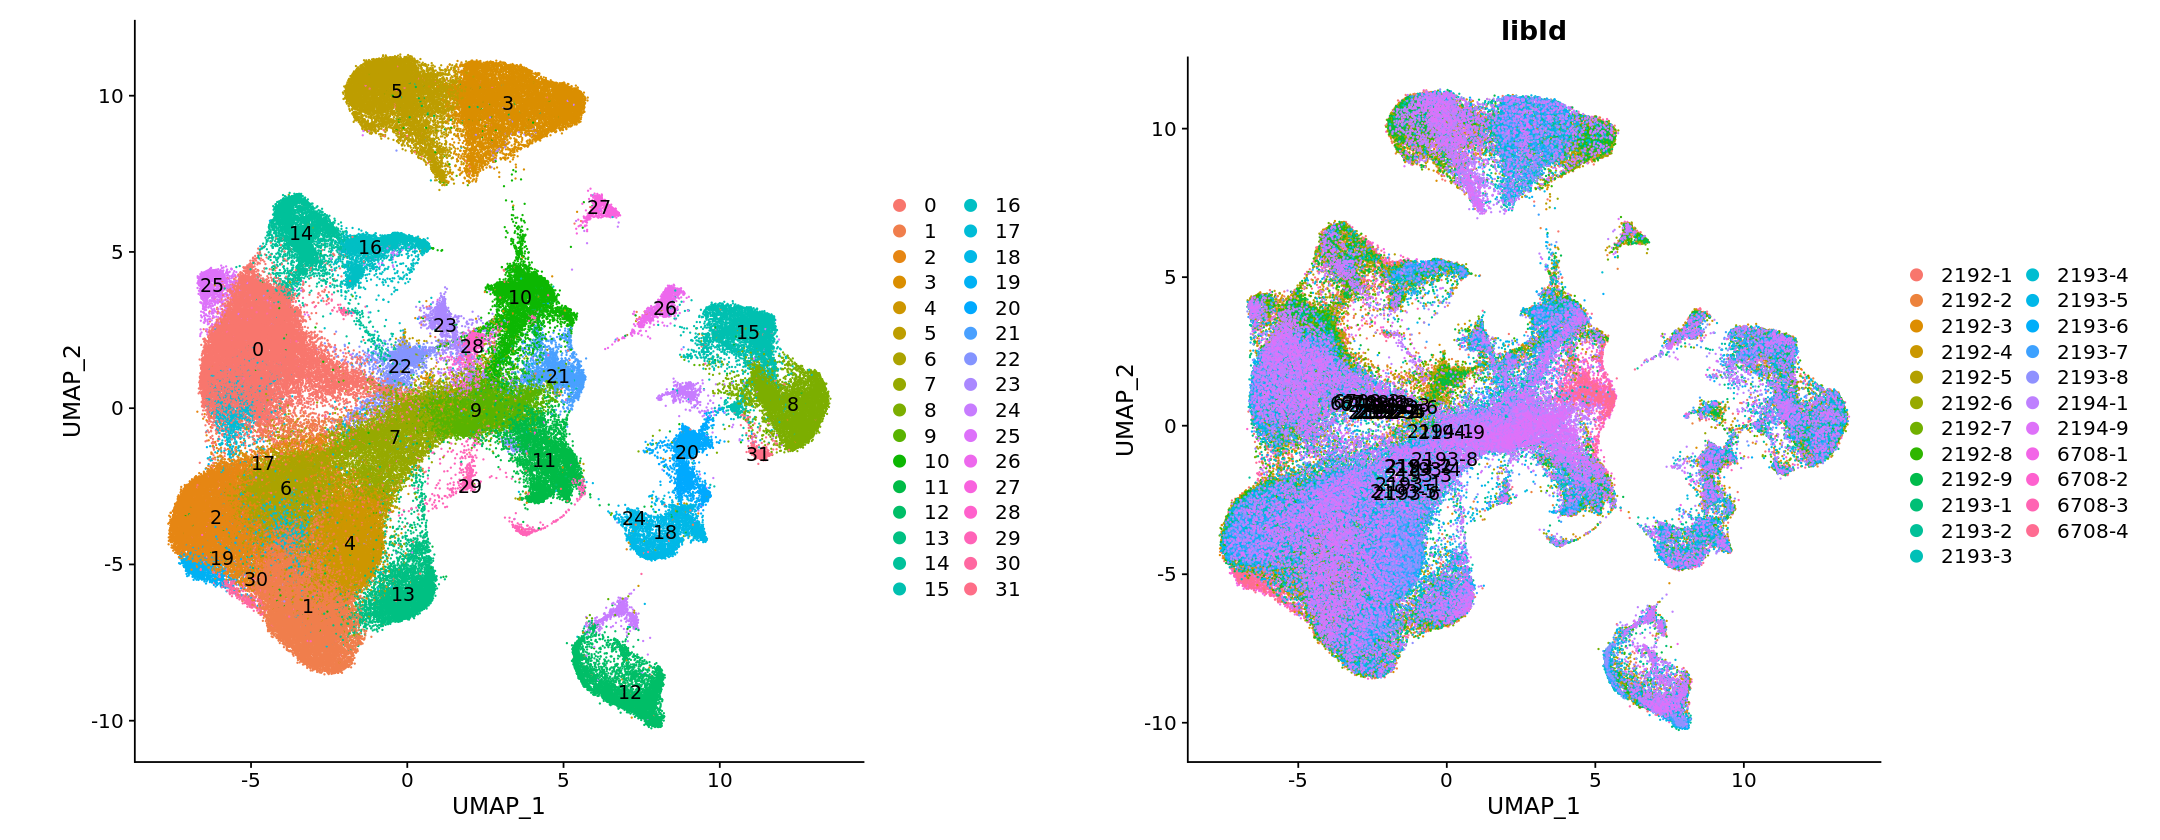

In [4]:
options(repr.plot.width=18, repr.plot.height=7)
plot_grid(
    DimPlot(seurat, reduction="umap", label=T,raster=FALSE)+coord_fixed(),
    #DimPlot(seurat, reduction="umap", group.by="sampleId", label=T)+coord_fixed(),
    DimPlot(seurat, reduction="umap", group.by="libId", label=T,raster=FALSE)+coord_fixed(),
    nrow=1
)

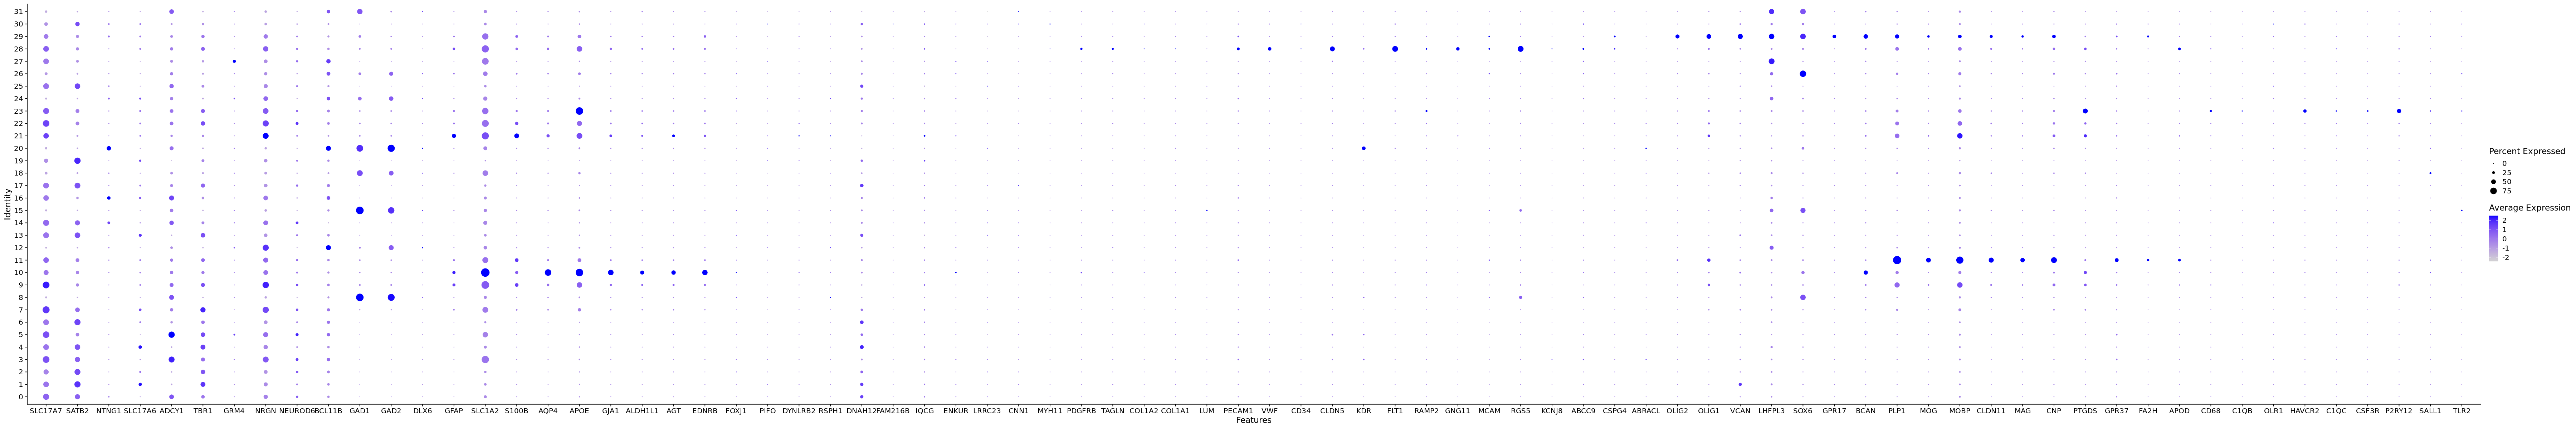

In [6]:
selectMarkers = c(
    "SLC17A7","SATB2",'NTNG1','SLC17A6','ADCY1','TBR1','GRM4','NRGN','NEUROD6','BCL11B', # Excit
    "GAD1", "GAD2",'DLX6','DLX6-AS1', # Inhib,
    "GFAP", "SLC1A2", "SLC1A2", "S100B", "AQP4", "APOE",'GJA1','ALDH1L1','AGT','EDNRB', # Astrocytes
    "FOXJ1", "PIFO", "DYNLRB2", "RSPH1", "DNAH12", "FAM216B", "ZMYDN10", "IQCG", "ENKUR","LRRC23", # Ependymal
    "CNN1", "MYH11", "PDGFRB", "TAGLN", "ALPHA-SMA", # VSMC
    "COL1A2", 'COL1A1','LUM','PDGFRALPHA',# VLMC
    "PECAM1","VWF","CD34","VECAD" ,"CLDN5","KDR","CD105",'FLT1','RAMP2','GNG11',# Endotheial
    "PDGFRB", "MCAM", "RGS5", "ALPHA-SMA", "KCNJ8",'TAGLN','COX4l2','MOTCH3','ABCC9','CSPG4', # Pericytes
    "ABRACL", "PDGFRALPHA", "OLIG2", "CSPG4", "OLIG1", "VCAN",'LHFPL3','SOX6','GPR17','BCAN', # OPC
    "PLP1",'MOG','MOBP','CLDN11','MAG','CNP','PTGDS','GPR37','FA2H','APOD', # Oligo
    'CD68','C1QB','OLR1','HAVCR2','C1QC','CSF3R','CS3CR1','P2RY12','SALL1','TLR2'# Microglia
)


#selectMarkers=str_to_title(selectMarkers)

selectMarkers=selectMarkers[!duplicated(selectMarkers)]

options(repr.plot.height=10,repr.plot.width=60)
DotPlot(seurat, features = selectMarkers)





In [7]:
seurat@meta.data$class='Uncertain'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(0,1,2,3,4,5,6,7,12,13,14,16,17,19,25,30),]$class='Excit_Neuron'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(8,15,18,20),]$class='Inhibit_Neuron'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(10),]$class='Astrocytes'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(11),]$class='Oligo'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(28),]$class='Endotheial'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(29,26,27),]$class='OPC'
#seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(),]$class='Microglia'

unique(seurat@meta.data[seurat@meta.data$class=='Uncertain',]$seurat_clusters)




[1] 23 21 24 9  31 22
32 Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ... 31

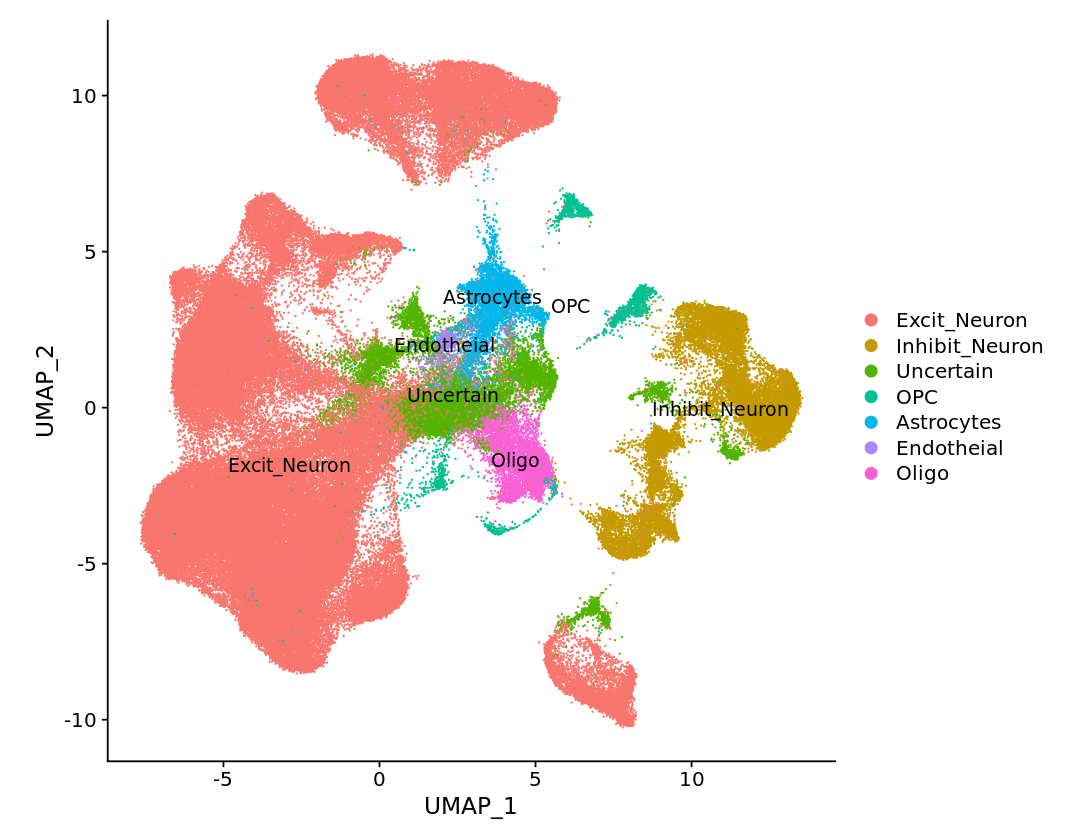

In [9]:
Idents(seurat) = "class"
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(seurat, reduction="umap", label=T,raster=FALSE)+coord_fixed()

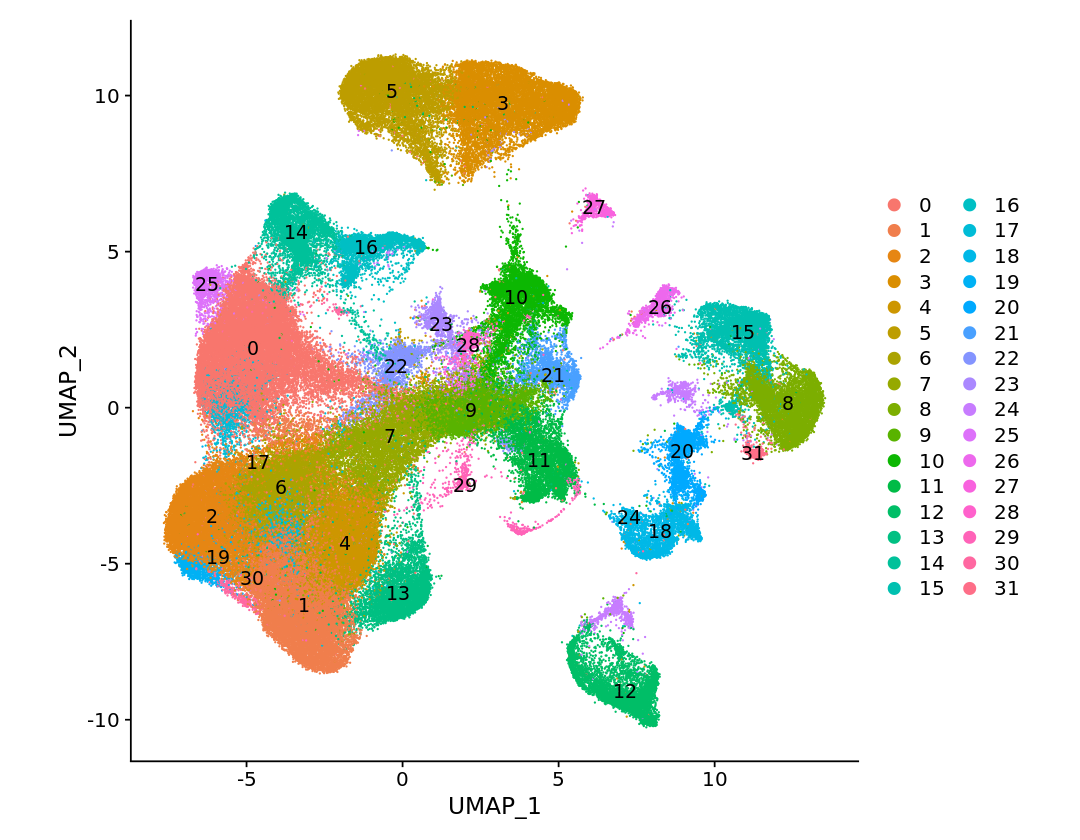

In [11]:
df_test=seurat@reductions$umap@cell.embeddings
df_test=as.data.frame(df_test)
df_test$X=rownames(df_test)

df_meta=seurat@meta.data
df_meta=as.data.frame(df_meta)
df_meta$X=rownames(df_meta)
df_meta=df_meta[,c('nFeature_RNA','X','seurat_clusters')]

df_test=left_join(df_test,df_meta,by='X')


Idents(seurat) = "seurat_clusters"
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(seurat, reduction="umap", label=T,raster=FALSE)+coord_fixed()


In [12]:
# 每个class抽样80%，最多500个细胞
sampleRatio = 0.8
maxCell = 5000
sampleDf = seurat@meta.data[, c("class"), drop=F]
sampleList = split(sampleDf, sampleDf$class)
sampleList = lapply(sampleList, function(x) {
    sampleSize = as.integer(nrow(x)*0.8)
    if (sampleSize > maxCell) {
        sampleSize = maxCell
    }
    sampleIdx = 1:nrow(x)
    sampleIdx = sample(1:nrow(x), size=sampleSize, replace=F)
    return(x[sampleIdx,,drop=F])
})
sampleDf = Reduce(rbind, sampleList)
str(sampleDf)
table(sampleDf$class)

trainSeurat = seurat[,rownames(sampleDf)]
table(trainSeurat$class)

'data.frame':	26585 obs. of  1 variable:
 $ class: chr  "Astrocytes" "Astrocytes" "Astrocytes" "Astrocytes" ...



    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron          Oligo 
          4488            690           5000           5000           4287 
           OPC      Uncertain 
          2120           5000 


    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron          Oligo 
          4488            690           5000           5000           4287 
           OPC      Uncertain 
          2120           5000 

In [13]:
Idents(trainSeurat) = "class"
classMarker = FindAllMarkers(trainSeurat)
#write_tsv(classMarker, paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))




Calculating cluster Astrocytes

Calculating cluster Endotheial

Calculating cluster Excit_Neuron

Calculating cluster Inhibit_Neuron

Calculating cluster Oligo

Calculating cluster OPC

Calculating cluster Uncertain




    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron          Oligo 
            37             10              3             39             16 
           OPC      Uncertain 
            13             22 

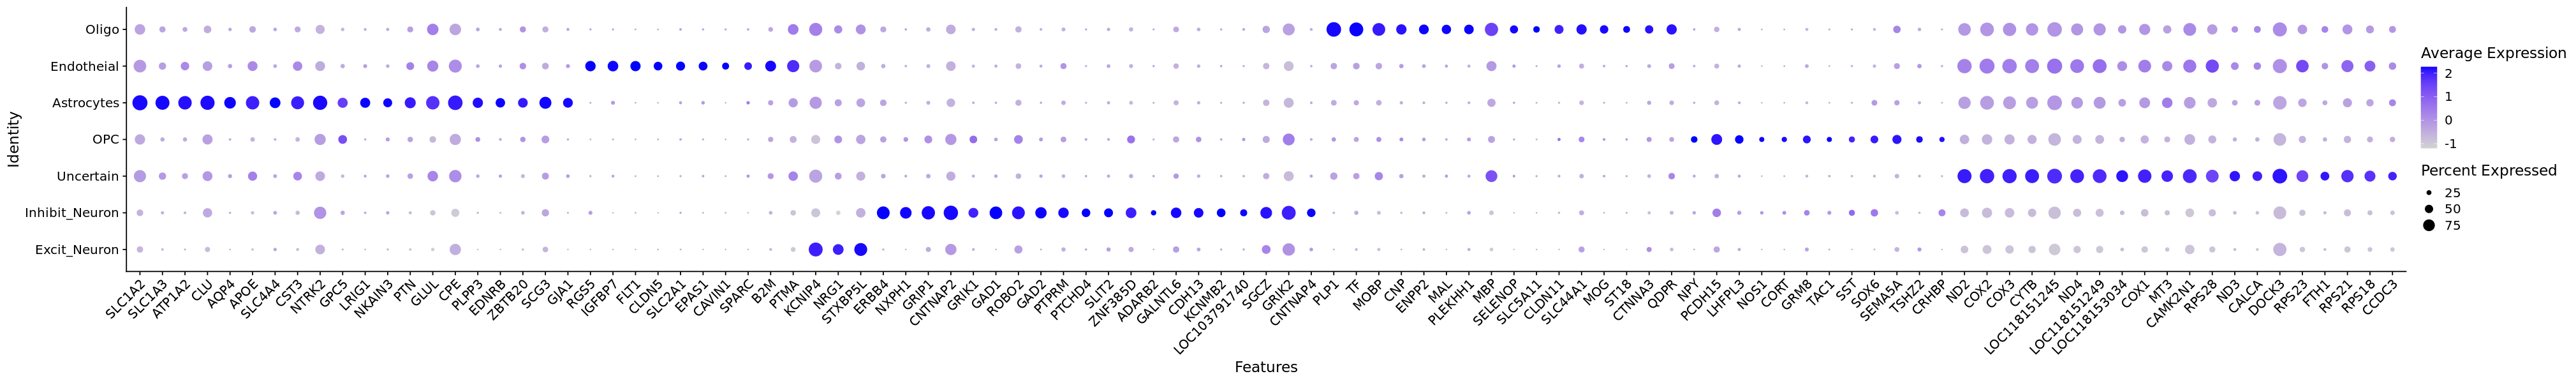

In [14]:
#classMarker = read_tsv(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))
classMarker = subset(classMarker, p_val_adj < 0.01 & avg_log2FC > 1)
table(classMarker$cluster)

classMarkerTop = classMarker %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)
options(repr.plot.width=length(unique(classMarkerTop$gene))/3, repr.plot.height=5)
Idents(seurat) = "class"
DotPlot(seurat, features=unique(c(classMarkerTop$gene))) + RotatedAxis()

In [15]:
trainDf = as.data.frame(t(as.matrix(trainSeurat[["SCT"]]@data[unique(classMarker$gene), ])))
trainDf$class = trainSeurat$class
trainDf = subset(trainDf, class != "Uncertain")
trainDf$class = factor(trainDf$class)
# We need to modify the name of the columns
colnames(trainDf) = paste0("col_", colnames(trainDf))
colnames(trainDf) = gsub("-", "_", colnames(trainDf))

rf = randomForest(col_class~., data=trainDf, ntree=500)
#saveRDS(rf, paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.class.randomForest.20220822.rds"))

 num [1:6, 1:7] 4334 74 71 61 94 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:6] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...
  ..$ : chr [1:7] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...


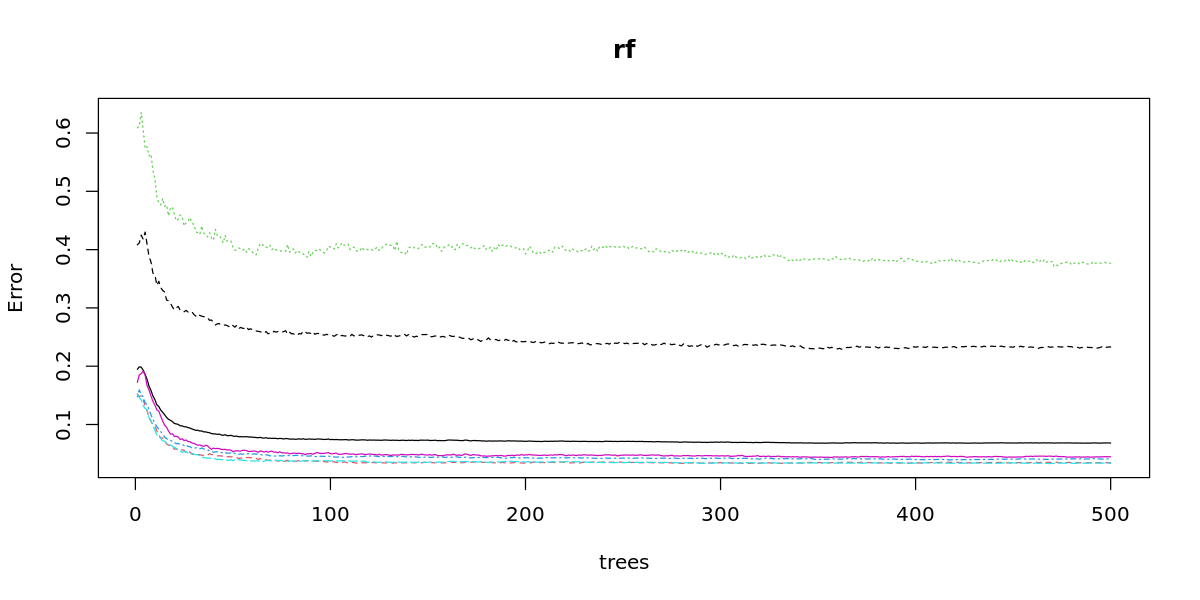

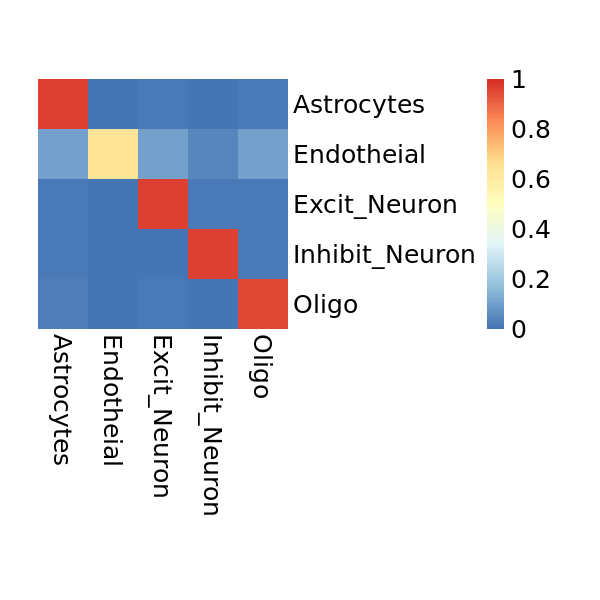

In [16]:
#rf = readRDS(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.class.randomForest.20220822.rds"))
str(rf$confusion)
options(repr.plot.width=10, repr.plot.height=5)
plot(rf)

confusionRatio = t(apply(rf$confusion[1:5, 1:5], 1, function(x) {x/sum(x)}))
options(repr.plot.width=5, repr.plot.height=5)
pheatmap(confusionRatio, breaks=seq(0,1,0.01), cluster_rows=F, cluster_cols=F, border_color=NA, cellwidth=30, cellheight=30, fontsize=15)

 'matrix' num [1:170385, 1:6] 0 0 0.004 0.004 0.138 0 0.028 0.032 0.004 0.002 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:170385] "6708-1_CELL197_N2" "6708-1_CELL2028_N1" "6708-1_CELL1614_N1" "6708-1_CELL2834_N1" ...
  ..$ : chr [1:6] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...


cellId             maxPredClassScore maxPredClass  
1 6708-1_CELL197_N2  0.998             Excit_Neuron  
2 6708-1_CELL2028_N1 0.996             Excit_Neuron  
3 6708-1_CELL1614_N1 0.976             Inhibit_Neuron
4 6708-1_CELL2834_N1 0.990             Excit_Neuron  
5 6708-1_CELL230_N2  0.206             Oligo         
6 6708-1_CELL3602_N1 0.998             Excit_Neuron

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1840  0.7420  0.9160  0.8309  0.9800  1.0000 

[1] TRUE

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



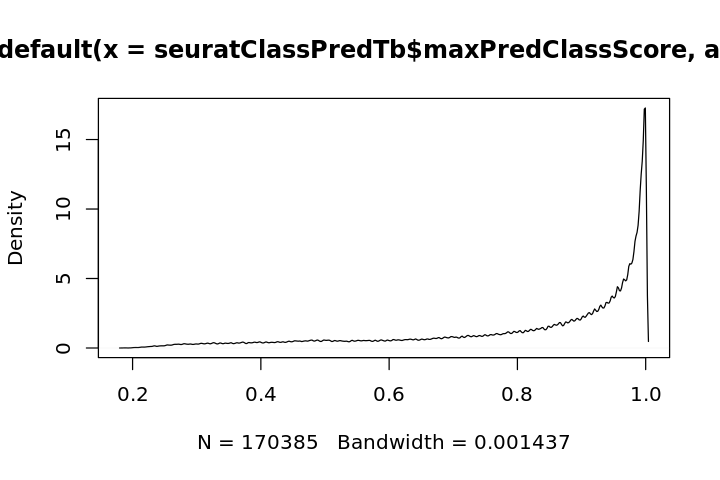

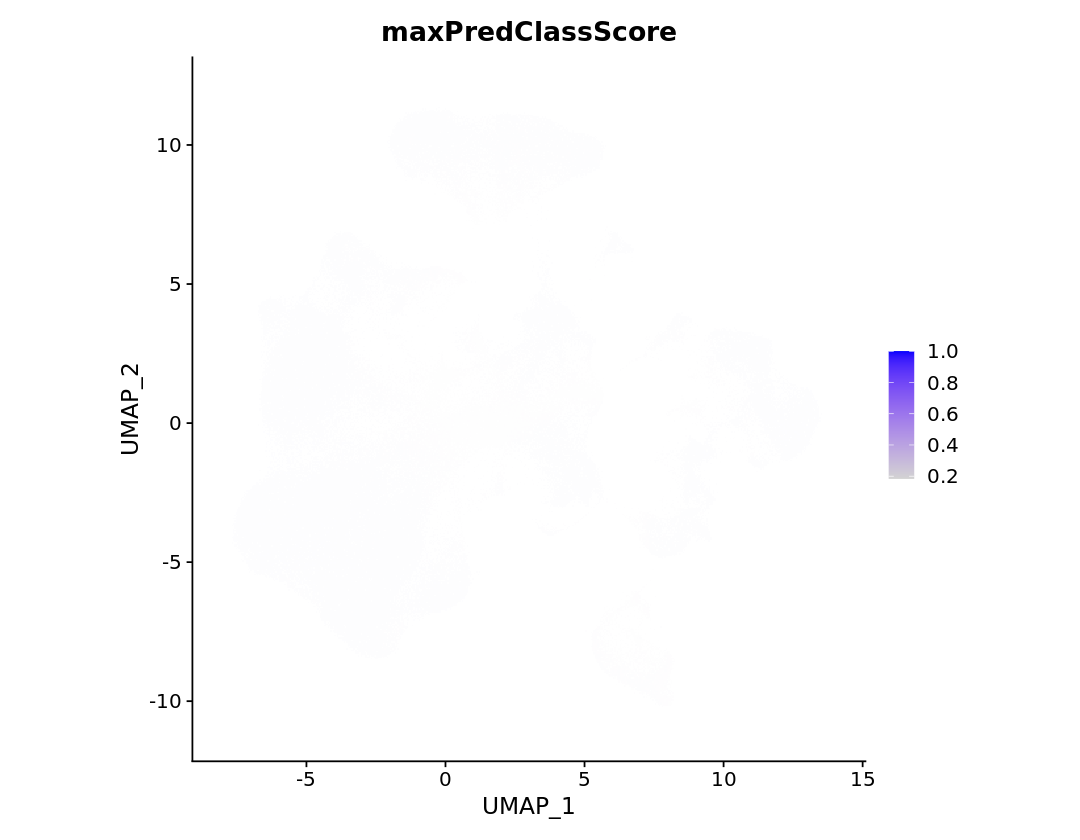

In [17]:
# Apply the trainer to filter cells
seuratCountDf = as.data.frame(t(as.matrix(seurat[["SCT"]]@data[unique(classMarker$gene), ])))
colnames(seuratCountDf) = paste0("col_", colnames(seuratCountDf))
colnames(seuratCountDf) = gsub("-", "_", colnames(seuratCountDf))
seuratClassPred = predict(rf, seuratCountDf, type="prob")
str(seuratClassPred)

seuratClassPredTb = tibble(
    cellId = rownames(seuratClassPred),
    maxPredClassScore = apply(seuratClassPred, 1, max),
    maxPredClass = apply(seuratClassPred, 1, function(x) {names(x)[which.max(x)]})
)
head(seuratClassPredTb)

summary(seuratClassPredTb$maxPredClassScore)
options(repr.plot.width=6, repr.plot.height=4)
plot(density(seuratClassPredTb$maxPredClassScore, adjust=0.1))

identical(seuratClassPredTb$cellId, rownames(seurat@meta.data))
tmpDf = as.data.frame(seuratClassPredTb[c("maxPredClassScore", "maxPredClass")])
rownames(tmpDf) = seuratClassPredTb$cellId

seurat = AddMetaData(seurat, tmpDf)

options(repr.plot.width=9, repr.plot.height=7)
FeaturePlot(seurat, reduction="umap", features="maxPredClassScore",raster=FALSE)+coord_fixed()


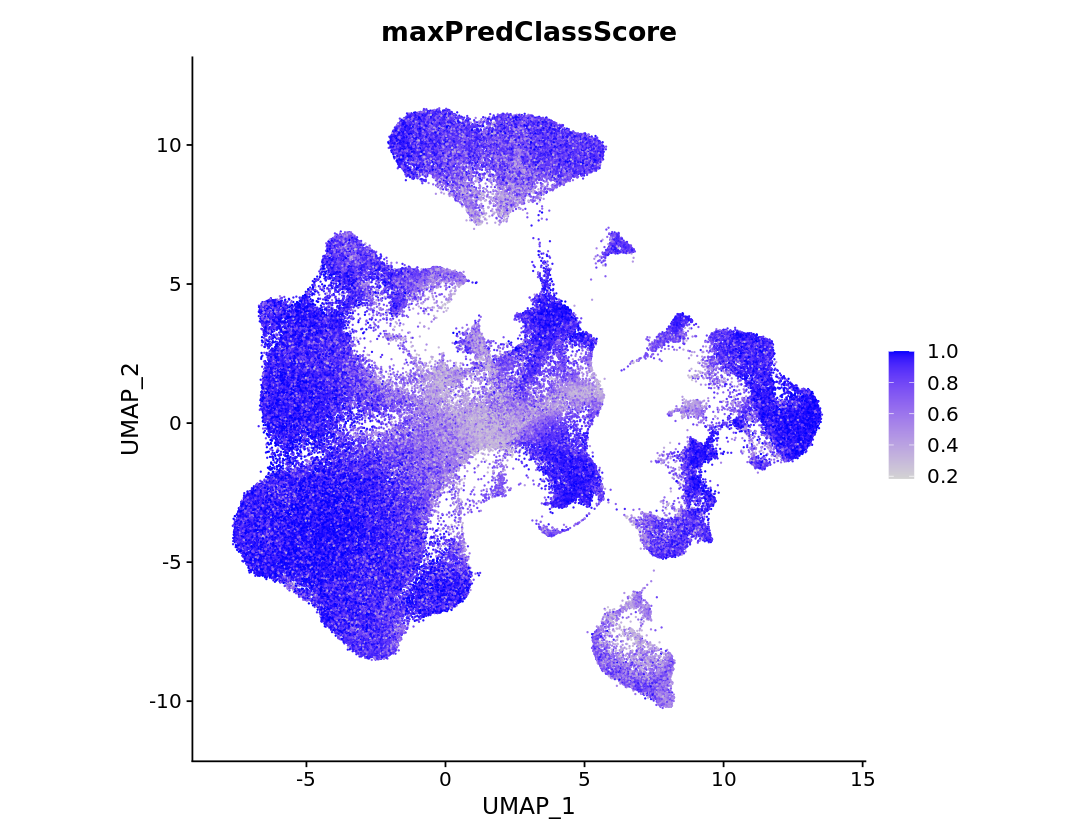

In [20]:
options(repr.plot.width=9, repr.plot.height=7)
FeaturePlot(seurat, reduction="umap", features="maxPredClassScore",raster=FALSE)+coord_fixed()


In [18]:
# Filter class outliers
# Removed clusters classified with ambiguous labels
# Removed cells classified with a different label from the majority of cells in its clusters
# Removed outliers when clustering, typically on the fringes of clusters in U-map space

Idents(seurat) = "seurat_clusters"
cellNum0 = ncol(seurat)
classFiltSeurat = subset(seurat, maxPredClassScore >= 0.8)
cellNum1 = ncol(classFiltSeurat)
message("Filt cell ratio: ", cellNum1/cellNum0)




Filt cell ratio: 0.693118525691816



In [22]:
classFiltSeurat

An object of class Seurat 
63687 features across 118097 samples within 2 assays 
Active assay: SCT (30768 features, 5000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [19]:
table(classFiltSeurat$maxPredClass)


    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron          Oligo 
          5278            285          91691          14037           5236 
           OPC 
          1570 

In [21]:
saveRDS(classFiltSeurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/marmoset/0619snrna_data/marmoset_snrna_all_soupX_fil800_SCT_0619_anno.rds')



In [ ]:
suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(randomForest))
suppressMessages(library(harmony))
options(future.globals.maxSize= 891289600)

dataDir='/home/liuyx/liuyuxuan/spa_seurat/cla/marmoset/0619snrna_data'
classFiltSeurat = readRDS(paste0(dataDir, "/marmoset_snrna_all_soupX_fil800_SCT_0619_anno.rds"))

# Do sct together
classFiltSeurat = SCTransform(
    classFiltSeurat, assay="RNA",
    ncells=ncol(classFiltSeurat[["RNA"]]),
    variable.features.n=5000,
    vars.to.regress="percent.mt",
    return.only.var.genes = T,
    method="glmGamPoi"
)
classFiltSeurat = classFiltSeurat %>%
    RunPCA(npcs=100, verbose = FALSE) %>%
    FindNeighbors(dims = 1:50) %>%
    FindClusters(verbose = FALSE) %>%
    RunUMAP(dims = 1:50)

saveRDS(classFiltSeurat,paste0(dataDir, "/marmoset_snrna_all_soupX_fil800_SCT_0619_anno_SCT.rds"))

